# Check Effective Ringdown Frequency Implementation

* fix implementatin of HM coprecessing eff ringdown freqs by making sure that sign of || final spin is used to select whether pro or retrograde modes are used
* make sure that the non-precessing final spin being used with PhenomXP(with settings to return PhenomX ) gives the correct limits and had the correct smoothness


In [1]:
# Setup ipython environment
%load_ext autoreload
%autoreload 2
%matplotlib inline
from matplotlib.pyplot import *
from numpy import *
from positive import *
from nrutils import scsearch, gwylm
from glob import glob
import xcp
from xcp import determine_data_fitting_region,calibration_catalog,metadata_dict,template_amp_phase,advanced_gmvx_plot
import lalsimulation as lalsim

(positive)>> Applying custom matplotlib settings.
(init)>> Warm greetings from XCP.
(xcp.core)>> Catalog of calibration runs stored to "xcp.calibration_catalog"
(xcp.core)>> Metadata dictionary for calibration runs stored to "xcp.metadata_dict"
(xcp.core)>> Metadata dictionary for Ed's catalog paper stored to "xcp.catalog_paper_metadata"


In [2]:
?lalsim.SimPhenomPNRfRingEff

Docstring: SimPhenomPNRfRingEff(REAL8 m1_SI, REAL8 m2_SI, REAL8 chi1x, REAL8 chi1y, REAL8 chi1z, REAL8 chi2x, REAL8 chi2y, REAL8 chi2z, Dict lalParams) -> REAL8
Type:      builtin_function_or_method


In [3]:
?lalsim.SimPhenomPNRafinal

Docstring: SimPhenomPNRafinal(REAL8 m1_SI, REAL8 m2_SI, REAL8 chi1x, REAL8 chi1y, REAL8 chi1z, REAL8 chi2x, REAL8 chi2y, REAL8 chi2z, Dict lalParams) -> REAL8
Type:      builtin_function_or_method


In [4]:
#
def PNRfRingEffaFinal( q, a1, theta_LS, pflag=None, fsflag=None ):
    
    # Import usefuls 
    from numpy import ndarray, array, arange, double
    from positive.units import codef,codeh,codehf,physf
    from positive import sYlm
    import lalsimulation as lalsim
    import lal
    
    #
    m1,m2 = q2m1m2(float(q))
    s1 = array( [a1*sin(theta_LS),0,a1*cos(theta_LS)] )
    
    #
    Mtot = 100.0
    M1 = m1 * Mtot/ ( m1 + m2 )
    M2 = m2 * Mtot / ( m1 + m2 )
    
    #
    lalparams = lal.CreateDict()
    # Turn off multibanding
    lalsim.SimInspiralWaveformParamsInsertPhenomXHMThresholdMband(lalparams, 0)
    # Tell the model to return the coprecessing mode -- only works on our development branches
    lalsim.SimInspiralWaveformParamsInsertPhenomXReturnCoPrec(lalparams, 1)
    #
    if not (fsflag is None):
        lalsim.SimInspiralWaveformParamsInsertPhenomXPFinalSpinMod( lalparams, fsflag )
    #
    if not (pflag is None):
        lalsim.SimInspiralWaveformParamsInsertPhenomXPrecVersion( lalparams, pflag )
    #
    distance_Mpc= 100.0
    distance_SI    = distance_Mpc*1.0e6*lal.PC_SI
    m1_SI = lal.MSUN_SI*M1
    m2_SI = lal.MSUN_SI*M2
    chi1x, chi1y, chi1z = s1
    chi2x, chi2y, chi2z = 0,0,0
    
    #
    # print(chi1x, chi1y, chi1z)
    fRingEff = lalsim.SimPhenomPNRfRingEff( m1_SI, m2_SI, chi1x, chi1y, chi1z, chi2x, chi2y, chi2z, lalparams ) 
    aFinal   = lalsim.SimPhenomPNRafinal( m1_SI, m2_SI, chi1x, chi1y, chi1z, chi2x, chi2y, chi2z, lalparams ) 
    
    #
    return (fRingEff, aFinal)

In [5]:

#
eps = 0.001

#
q = 8
a1 = 0.8
theta_LS = linspace(0+eps,pi-eps)


In [13]:
?remnant

Signature: remnant(m1, m2, chi1, chi2, arxiv=None, verbose=False, L_vec=None)
Docstring:
High level function for calculating remant mass and spin for nonprecessing BBH systems.

Available arxiv ids are:
* 1611.00332 by Jimenez et. al.
* 1406.7295 by Healy et. al.

This function automatically imposes m1,m2 conventions.

spxll'17
File:      ~/JOKI/Libs/KOALA/positive_dev/positive/physics.py
Type:      function


In [21]:
m1,m2 = q2m1m2(q)
_,Xf1 = remnant(m1,m2,a1,0)
_,Xf2 = remnant(m1,m2,-a1,0)

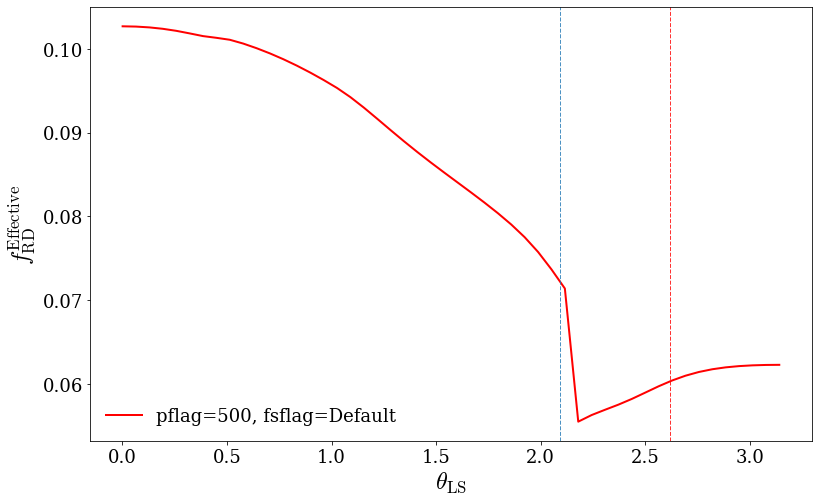

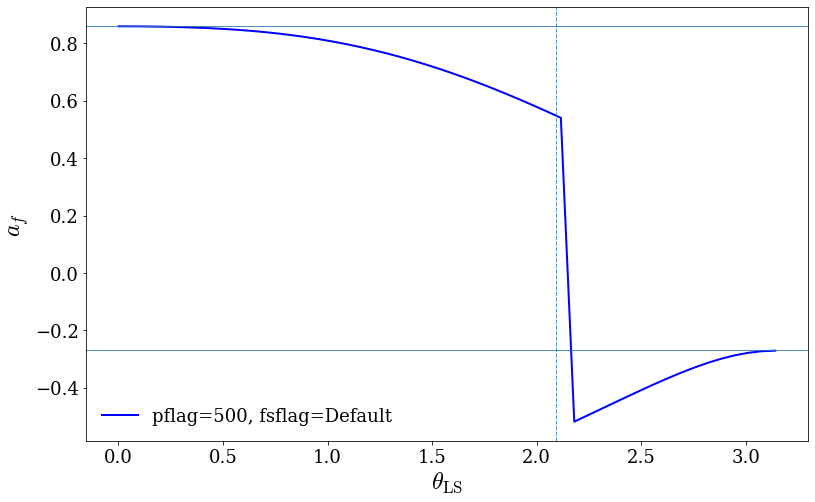

In [22]:


#
fRD = array( [ PNRfRingEffaFinal( q, a1, th, pflag=501 )[0] for th in theta_LS ] )
af  = array( [ PNRfRingEffaFinal( q, a1, th, pflag=501 )[1] for th in theta_LS ] )

#
figure( figsize=2*figaspect(0.618) )
plot( theta_LS, fRD, lw=2, label='pflag=500, fsflag=Default', c='r'  )
xlabel(r'$\theta_{\mathrm{LS}}$')
ylabel(r'$f_{\mathrm{RD}}^\mathrm{Effective}$')
axvline( 120*pi/180, ls='--' )
axvline( 150*pi/180, ls='--',c='r' )
# axhline( )
legend()

#
figure( figsize=2*figaspect(0.618) )
plot( theta_LS, af, lw=2, label='pflag=500, fsflag=Default', c='b'  )
xlabel(r'$\theta_{\mathrm{LS}}$')
ylabel(r'$a_f$')
axvline( 120*pi/180, ls='--' )
axhline( Xf1 )
axhline( Xf2 )
legend()

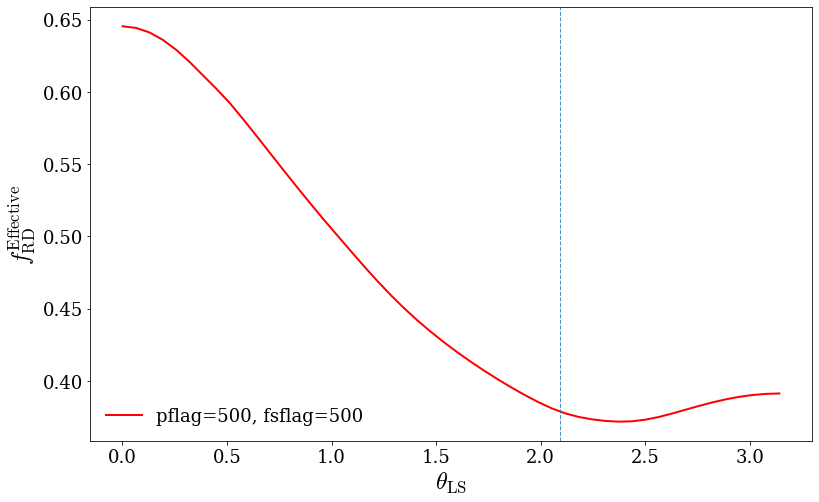

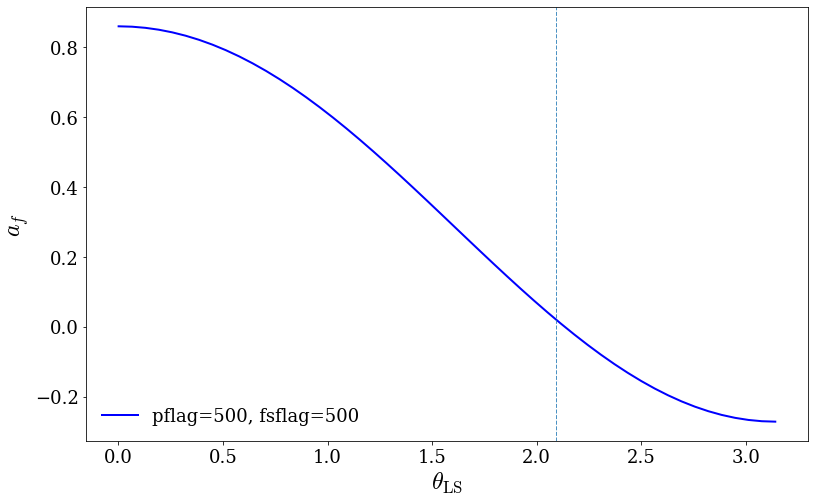

In [7]:


#
fRD = array( [ PNRfRingEffaFinal( q, a1, th, pflag=501, fsflag=500 )[0] for th in theta_LS ] )
af  = array( [ PNRfRingEffaFinal( q, a1, th, pflag=500, fsflag=500 )[1] for th in theta_LS ] )

#
figure( figsize=2*figaspect(0.618) )
plot( theta_LS, 2*pi*fRD, lw=2, label='pflag=500, fsflag=500', c='r'  )
xlabel(r'$\theta_{\mathrm{LS}}$')
ylabel(r'$f_{\mathrm{RD}}^\mathrm{Effective}$')
axvline( 120*pi/180, ls='--' )
legend()

#
figure( figsize=2*figaspect(0.618) )
plot( theta_LS, af, lw=2, label='pflag=500, fsflag=500', c='b'  )
xlabel(r'$\theta_{\mathrm{LS}}$')
ylabel(r'$a_f$')
axvline( 120*pi/180, ls='--' )
legend()


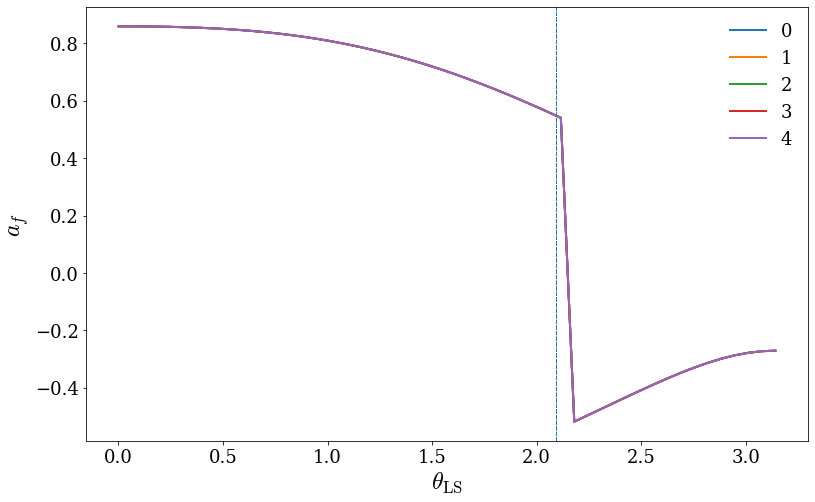

In [8]:


#
fRD = array( [ PNRfRingEffaFinal( q, a1, th, pflag=501, fsflag=4 )[0] for th in theta_LS ] )

#
m1,m2 = q2m1m2(q)
afinal_reference = array([ remnant( m1, m2, [0,sin(th)*a1,cos(th)*a1], [0,0,0], arxiv=None, verbose=False, L_vec=[0,0,1] ) for th in theta_LS ])

#
figure( figsize=2*figaspect(0.618) )
for kk in [0,1,2,3,4]:

    af  = array( [ PNRfRingEffaFinal( q, a1, th, fsflag=kk )[1] for th in theta_LS ] )

    # #
    # figure( figsize=2*figaspect(0.618) )
    # plot( theta_LS, fRD, lw=2, label='pflag=500, fsflag=500', c='r'  )
    # xlabel(r'$\theta_{\mathrm{LS}}$')
    # ylabel(r'$f_{\mathrm{RD}}^\mathrm{Effective}$')
    # axvline( 120*pi/180, ls='--' )
    # legend()
    plot( theta_LS, af, lw=2, label=kk  )
    xlabel(r'$\theta_{\mathrm{LS}}$')
    ylabel(r'$a_f$')
    axvline( 120*pi/180, ls='--' )
legend()



In [9]:
from numpy import int32.

SyntaxError: invalid syntax (<ipython-input-9-7e7c8add84ec>, line 1)

In [ ]:
isinstance(2,int)

In [10]:
%%capture
#
m1,m2 = q2m1m2(q)
afinal_reference = array([ remnant( m1, m2, [0,sin(th)*a1,cos(th)*a1], [0,0,0], arxiv=None, verbose=False, L_vec=[0,0,1] ) for th in theta_LS ])
afinal_reference_noPrec = array([ remnant( m1, m2, a1*cos(th), 0, arxiv=None, verbose=False ) for th in theta_LS ])

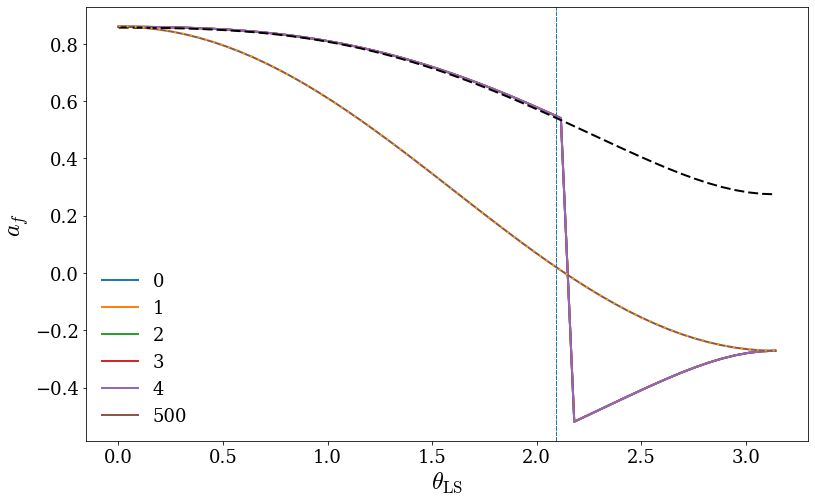

In [11]:
#
figure( figsize=2*figaspect(0.618) )
for kk in [0,1,2,3,4,500]:

    af  = array( [ PNRfRingEffaFinal( q, a1, th, fsflag=kk )[1] for th in theta_LS ] )

    # #
    # figure( figsize=2*figaspect(0.618) )
    # plot( theta_LS, fRD, lw=2, label='pflag=500, fsflag=500', c='r'  )
    # xlabel(r'$\theta_{\mathrm{LS}}$')
    # ylabel(r'$f_{\mathrm{RD}}^\mathrm{Effective}$')
    # axvline( 120*pi/180, ls='--' )
    # legend()
    plot( theta_LS, af, lw=2, label=kk  )
    xlabel(r'$\theta_{\mathrm{LS}}$')
    ylabel(r'$a_f$')
    axvline( 120*pi/180, ls='--' )
legend()

plot( theta_LS, afinal_reference[:,1], ls='--',c='k',lw=2 )
plot( theta_LS, afinal_reference_noPrec[:,1], ls=':',c='orange',lw=2 )


In [12]:
?remnant

Signature: remnant(m1, m2, chi1, chi2, arxiv=None, verbose=False, L_vec=None)
Docstring:
High level function for calculating remant mass and spin for nonprecessing BBH systems.

Available arxiv ids are:
* 1611.00332 by Jimenez et. al.
* 1406.7295 by Healy et. al.

This function automatically imposes m1,m2 conventions.

spxll'17
File:      ~/JOKI/Libs/KOALA/positive_dev/positive/physics.py
Type:      function
